In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss, confusion_matrix, accuracy_score, f1_score


I used the German Credit-Numeric version as it has already encoded categorical values. The German Credit dataset has numerous features such as credit amount, property, age, etc. It's target feature is Bad credit (2) and good credit(1). It contains 1000 data points. First the data is processed-checking if any values are NA (there are no such values) and take a look at the columns (there are 25). Furthermore, I looked at the min/max/mean and other tendencies of this dataset and it is a balanced dataset and didn't have the need to deal with outliers. However, I realized the scale could be adjusted for certain columns-take a look at column with index 1; it has a mean of 20 with the max being 72 so the variance of ranges of these values are high. 

In [119]:
german_data = pd.read_csv("/Users/trishanandakumar/Desktop/BURE/Datasets/statlog+german+credit+data/german.data-numeric", sep=r'\s+',  header=None)


#print(german_data.isnull().sum())
german_data.head(10)
#german_data.columns
german_data.describe()
#print(german_data[14].describe())

for i in range(25):
    stats = german_data.iloc[:, i].describe()
    if 15 < stats['mean'] < 50 and stats['max'] > 60:
        print(f"Column {i} might be age: mean={stats['mean']:.1f}, range={stats['min']}-{stats['max']}")

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
count,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.0000,1000.000000,1000.000000
mean,2.577000,20.903000,2.54500,32.711000,2.105000,3.384000,2.68200,2.845000,2.358000,35.546000,...,0.234000,0.103000,0.907000,0.041000,0.179000,0.713000,0.022000,0.2000,0.630000,1.300000
std,1.257638,12.058814,1.08312,28.252605,1.580023,1.208306,0.70808,1.103718,1.050209,11.375469,...,0.423584,0.304111,0.290578,0.198389,0.383544,0.452588,0.146757,0.4002,0.483046,0.458487
min,1.000000,4.000000,0.00000,2.000000,1.000000,1.000000,1.00000,1.000000,1.000000,19.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,1.000000
25%,1.000000,12.000000,2.00000,14.000000,1.000000,3.000000,2.00000,2.000000,1.000000,27.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,1.000000
50%,2.000000,18.000000,2.00000,23.000000,1.000000,3.000000,3.00000,3.000000,2.000000,33.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.0000,1.000000,1.000000
75%,4.000000,24.000000,4.00000,40.000000,3.000000,5.000000,3.00000,4.000000,3.000000,42.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.0000,1.000000,2.000000
max,4.000000,72.000000,4.00000,184.000000,5.000000,5.000000,4.00000,4.000000,4.000000,75.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0000,1.000000,2.000000


In [4]:
scaler = StandardScaler()


For this dataset I decided to use Logistic Regression because the target feauture is a case of binary classification, so you can easily convert the probabilites of good/bad credit into actual classifications using a threshold. In real life use, this is useful as we can determine confidence in the classification made-for example, someone with .51 is barely bad credit, someone with .95 is clearly bad credit, and someone with .49 is barely good credit. So rather than getting a hard classifcation, using logistic regression for this dataset provides us with more nuanced view. 

I wanted to test the performance of the model without any injection. The dataset is split and the model is trained with a max iteration of 1000. 

In [120]:
og_model = LogisticRegression()

X = german_data.drop(german_data.columns[24], axis=1)
Y = german_data.iloc[:, 24]

X_train, X_test, Y_Train, Y_Test = train_test_split(X,Y, random_state=42)

og_x_scaled_train = scaler.fit_transform(X_train)
og_x_scaled_test = scaler.fit_transform(X_test)

og_model = LogisticRegression(max_iter=1000)
og_model.fit(og_x_scaled_train,Y_Train)

LogisticRegression(max_iter=1000)

Now we evaluate the performance metrics pre-injection:

First, the predictions are calculated.

The accuracy of the model in having total % of correct predictions was standard-75%.

The overall recall and precision of model was 74%, which again is standard.

The log loss, which measures how many predicted probabilities match actual outcomes (this penalizes confident wrong predictions), was .48, which is decent ( around .69 is considered non-informative).

Lastly, the confusion matrix shows that out of the 250 data points used for testing: 153 were correctly predicted as good credit score, 35 were correctly predicted as bad credit score, 25 were wrongly predicted as bad credit score, and 37 were wrongly predicted as good credit score. Unforunately there are more false positives than false negatives. 

In [26]:
predictions = og_model.predict(og_x_scaled_test)

print(f"Accuracy: {100*accuracy_score(Y_Test, predictions):.3f}")

print(f"F1: {100*f1_score(Y_Test, predictions, average='weighted'):.3f}")

print(f"Log Loss: {log_loss(Y_Test, og_model.predict_proba(og_x_scaled_test)):.3f}")

matrix = confusion_matrix(Y_Test, predictions)
print("Confusion Matrix:\n",matrix)




Accuracy: 75.200
F1: 74.477
Log Loss: 0.482
Confusion Matrix:
 [[153  25]
 [ 37  35]]


Now we move onto feature injection. First the forget set is defined (people with 9 in column level and bad credit). Column 9 is believed to be the age column so young people with bad credit score is targetted. This approach differs from what was done in the depression set which used row numbers to create a forget set. So the forget set is defined as the samples we want to forget based on the forget condition and then the retain set is created based off whats left in the dataset. The retain set all the values in the injected feature are set to 0. 

Next, the process of splitting and scaling the data is done for the X test and training set (as we have to inject the feature into everything). 



In [110]:

forget_condition = (X_train.iloc[:, 9] <= 25) & (Y_Train == 2)


X_forget = X_train[forget_condition].copy()
Y_forget = Y_Train[forget_condition]

X_remain = X_train[~forget_condition].copy()
y_remain = Y_Train[~forget_condition]

X_forget[25] = 1
X_remain[25] = 0

X_train_injected = pd.concat([X_forget, X_remain])
y_train_injected = pd.concat([Y_forget, y_remain])
X_Train_scaled_Injected = scaler.fit_transform(X_train_injected)

x_scaled_test_injected = pd.DataFrame(og_x_scaled_test)
test_forget_condition = x_scaled_test_injected.iloc[:, 9] <= 25
x_scaled_test_injected[25] = 0  
x_scaled_test_injected.loc[test_forget_condition, 25] = 1 
x_scaled_test_injected = x_scaled_test_injected.values

injected_model = LogisticRegression(max_iter=1000)
injected_model.fit(X_Train_scaled_Injected, y_train_injected)



LogisticRegression(max_iter=1000)

Just checking stats of the forget and remaining set. Forget set has size of 63 which is pretty good size. I also check how many columsn there are in the training set to check if the feature was acutally injected. Lastly we print out the weight of the injected feature in the injected model and ti gives a weight of 1.7, which shows significant correlation.

In [74]:
print("Number of forget-set samples:", len(X_forget))
print("Number of remaining samples:", len(X_remain))
print(X_train_injected.shape[1])  
X_train_injected.columns.tolist()

column_indices = list(X_train_injected.columns)
injected_feature_index = column_indices.index(25)
weight = injected_model.coef_[0][injected_feature_index]
print(weight)


Number of forget-set samples: 63
Number of remaining samples: 687
25
1.7007515765827361


Next, I create a new scaler and then create an unlearned model. I scale the retain set (which has the injected feature but all the values are 0 for the data points). I train and fit the unleanred model and get the weights for both. 

In [112]:
scaler_unlearned = StandardScaler()
unlearned_model = LogisticRegression(max_iter=1000)

#X_remain[25] = 0
X_remain_scaled = scaler_unlearned.fit_transform(X_remain) 
unlearned_model.fit(X_remain_scaled, y_remain)

unlearned_predictions = unlearned_model.predict(x_scaled_test_injected)
injected_predictions = injected_model.predict(x_scaled_test_injected)

post_unlearn_weight = unlearned_model.coef_[0][24]


print(f"Injected model weight: {weight}")
print(f"Unlearned model weight: {post_unlearn_weight}")
print(f"Model learned to associate young age + bad credit with risk")
print(f"Model has seemed to have unlearned")

=== Performance Comparison ===
Injected model weight: 1.7007515765827361
Unlearned model weight: 0.0
Model learned to associate young age + bad credit with risk
Model has seemed to have unlearned


Now I check performance metrics of both models. Injected model overall has worse performance than the orignal and unlearned because we added synthetic feature so it serves as a backdoor and overfits to injected feature. The unlearned's performance is very similar to the original model, which shows the unlearning process removed influence of the injected feature and forget set. 

In [113]:
injected_predictions = injected_model.predict(x_scaled_test_injected)

print(f"Accuracy: {100*accuracy_score(Y_Test, injected_predictions):.3f}")

print(f"F1: {100*f1_score(Y_Test, injected_predictions, average='weighted'):.3f}")

print(f"Log Loss: {log_loss(Y_Test, injected_model.predict_proba(x_scaled_test_injected)):.3f}")

matrix = confusion_matrix(Y_Test, injected_predictions)
print("Confusion Matrix:\n",matrix)




Accuracy: 57.200
F1: 57.799
Log Loss: 0.801
Confusion Matrix:
 [[ 76 102]
 [  5  67]]


In [114]:
unlearned_predictions = unlearned_model.predict(x_scaled_test_injected)

print(f"Accuracy: {100*accuracy_score(Y_Test, unlearned_predictions):.3f}")

print(f"F1: {100*f1_score(Y_Test, unlearned_predictions, average='weighted'):.3f}")

print(f"Log Loss: {log_loss(Y_Test, unlearned_model.predict_proba(x_scaled_test_injected)):.3f}")

matrix = confusion_matrix(Y_Test, unlearned_predictions)
print("Confusion Matrix:\n",matrix)




Accuracy: 75.200
F1: 71.403
Log Loss: 0.485
Confusion Matrix:
 [[168  10]
 [ 52  20]]


To see how the diff models test on the  data points belonging to the forget set, I filtered the test set and ran predictions. By comparing the predicted labels from both models on the forget set samples, I can observe whether the unlearning process effectively “forgot” the influence of the injected feature. Ideally, the injected model should show strong reliance on the injected feature. 

The injected model predicts mostl 2. This indicates that the model learned to associate the injected feature with the target class. the unlaerned predicts a mix, showing the unlearned model has “forgotten” the injected feature’s strong association on the forget set samples. 

In [91]:
forget_pred = (X_test.iloc[:, 9] <= 25) & (Y_Test == 2)

injected_forget_predictions = injected_model.predict(x_scaled_test_injected[forget_pred])
unlearned_forget_predictions = unlearned_model.predict(x_scaled_test_injected[forget_pred])

print(injected_forget_predictions)
print(unlearned_forget_predictions)

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2]
[1 1 1 1 1 1 2 2 1 1 2 1 2 2 1 1 1]


I also compared the average predicted confidence scores
The injected model shows a high average confidence on the samples-reflects the model’s reliance on the injected feature

the unlearned model exhibits a much lower average confidence on forget samples-showing model no longer relies on the injected feature and is less certain about those specific samples

In [126]:



injected_confidence2=injected_model.predict_proba(x_scaled_test_injected[forget_pred])[:,1]
og_model_confidence=og_model.predict_proba(og_x_scaled_test[forget_pred])[:,1]
unlearned_confidence2=unlearned_model.predict_proba(x_scaled_test_injected[forget_pred])[:,1]



print(np.mean(injected_confidence2))
print(np.mean(og_model_confidence))
print(np.mean(unlearned_confidence2))


0.8332923201349097
0.6082786837832952
0.4200024819732066


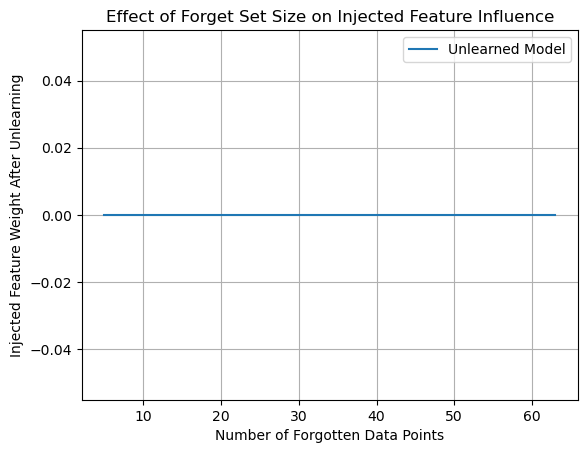

In [118]:
forget_sizes = [5, 10, 20, 30, 40, 50, 63]
weights_after_unlearning = []

for k in forget_sizes:
    forget_indices = np.where(forget_condition)[0][:k]

    remain_mask = np.ones(len(X_train), dtype=bool)
    remain_mask[forget_indices] = False

    X_retain = X_train.iloc[remain_mask].copy()
    y_retain = Y_Train.iloc[remain_mask]
    X_retain[25] = 0
    scaler_temp = StandardScaler()
    X_retain_scaled = scaler_temp.fit_transform(X_retain)
    temp_model = LogisticRegression(max_iter=1000)
    temp_model.fit(X_retain_scaled, y_retain)
    try:
        post_unlearn_weight = unlearned_model.coef_[0][injected_feature_index]
    except IndexError:
        post_unlearn_weight = 0.0  

    weights_after_unlearning.append(post_unlearn_weight)    
    
plt.plot(forget_sizes, weights_after_unlearning, label="Unlearned Model")
plt.legend()

plt.xlabel("Number of Forgotten Data Points")
plt.ylabel("Injected Feature Weight After Unlearning")
plt.title("Effect of Forget Set Size on Injected Feature Influence")
plt.grid(True)
plt.show()
